In [7]:
import numpy as np
from scipy.sparse import csr_matrix, coo_matrix
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt

# Load and preprocess data
def load_data(file_path):
    data = np.loadtxt(file_path)
    data = data[:, :3]  # Remove timestamp column

    n_users = int(np.max(data[:, 0]))
    n_items = int(np.max(data[:, 1]))

    user_indices = data[:, 0].astype(int) - 1
    item_indices = data[:, 1].astype(int) - 1
    ratings = data[:, 2]

    matrix = csr_matrix((ratings, (user_indices, item_indices)), shape=(n_users, n_items)).toarray()

    total_elements = matrix.size
    non_zero_elems = np.count_nonzero(matrix)
    sparsity = 1 - (non_zero_elems / total_elements)

    print(f"Number of users: {n_users}, Number of items: {n_items}")
    print(f"Sparsity of the matrix: {sparsity:.2%}")

    return matrix, n_users, n_items

# Normalize observed ratings
def normalize_ratings(matrix):
    non_zero_indices = (matrix != 0)
    rating_mean = np.mean(matrix[non_zero_indices])
    rating_std = np.std(matrix[non_zero_indices])
    print(f"Rating mean: {rating_mean}, Rating std: {rating_std}")
    return matrix, rating_mean, rating_std

# Define activation functions and forward pass
def relu(x):
    return np.maximum(0, x)

def forward_pass(X, weights, activations):
    z = X
    for i, (w, act) in enumerate(zip(weights, activations)):
        print(f"Layer {i}: Input shape {z.shape}, Weight shape {w.shape}")
        if z.shape[0] != w.shape[1]:
            raise ValueError(f"Mismatch in forward pass: input shape {z.shape} does not match weight shape {w.shape}.")
        z = act(np.dot(w, z))
        print(f"Layer {i}: Output shape {z.shape}")
    return z

# Compute Neural Tangent Kernel with sparse computation
def compute_kernel_sparse(X, weights, activations, chunk_size=100):
    n_samples = X.shape[1]
    data, row, col = [], [], []
    outputs = forward_pass(X, weights, activations)

    for i in range(0, n_samples, chunk_size):
        for j in range(i, n_samples, chunk_size):
            kernel_chunk = outputs[:, i:i + chunk_size].T @ outputs[:, j:j + chunk_size]
            sparse_chunk = coo_matrix(kernel_chunk)
            data.extend(sparse_chunk.data)
            row.extend(sparse_chunk.row + i)
            col.extend(sparse_chunk.col + j)

    sparse_kernel = coo_matrix((data, (row, col)), shape=(n_samples, n_samples))
    print(f"Sparse kernel matrix with {sparse_kernel.nnz} non-zero entries.")
    return sparse_kernel

# Complete the matrix

def complete_matrix_sparse(matrix, S, weights, activations, alpha=1e-3, rating_mean=0, rating_std=1, sample_size=5000):
    """
    Train on observed data and complete the matrix using sparse kernel matrix.
    """
    print("Training on observed data to complete the matrix...")

    # Compute the kernel for the full data using sparse computation
    X = matrix.T  # Transpose to align with samples (943 users)
    K = compute_kernel_sparse(X, weights, activations, chunk_size=50)

    # Subsample observed indices
    observed_indices = np.array(np.where(S == 1)).T
    sampled_indices = observed_indices[np.random.choice(len(observed_indices), size=sample_size, replace=False)]
    sampled_users, sampled_items = sampled_indices[:, 0], sampled_indices[:, 1]

    # Extract observed ratings
    Y_obs = matrix[sampled_users, sampled_items]
    print(f"Sampled observed ratings shape: {Y_obs.shape}")

    K_obs = K.tocsr()[sampled_users, :][:, sampled_users].toarray()
    print(f"Sampled kernel submatrix shape: {K_obs.shape}")
    alpha_I = alpha * np.eye(K_obs.shape[0])

    # Solve for coefficients
    alphas = np.linalg.solve(K_obs + alpha_I, Y_obs)
    print(f"Alphas shape: {alphas.shape}")

    K_full = K.tocsr()[:, sampled_users].toarray()
    predictions = K_full @ alphas
    print(f"Predicted full matrix shape: {predictions.shape}")

    completed_matrix = np.zeros(matrix.shape)
    for i, user in enumerate(sampled_users):
        if user < matrix.shape[0] and i < len(predictions):
            completed_matrix[user, sampled_items] = predictions[i]

    print("Matrix completion done.")

    return completed_matrix

# Plot the completed matrix
def plot_completed_matrix(matrix, title="Completed Matrix"):
    """
    Plots the completed matrix as a heatmap.
    """
    plt.figure(figsize=(12, 8))
    plt.imshow(matrix, aspect='auto', cmap='viridis', interpolation='nearest')
    plt.colorbar(label='Rating')
    plt.title(title)
    plt.xlabel("Items")
    plt.ylabel("Users")
    plt.show()


Number of users: 943, Number of items: 1682
Sparsity of the matrix: 93.70%
Rating mean: 3.52986, Rating std: 1.1256679707622492
Training on observed data to complete the matrix...
Layer 0: Input shape (1682, 943), Weight shape (50, 1682)
Layer 0: Output shape (50, 943)
Layer 1: Input shape (50, 943), Weight shape (50, 50)
Layer 1: Output shape (50, 943)
Sparse kernel matrix with 468049 non-zero entries.
Sampled observed ratings shape: (5000,)
Sampled kernel submatrix shape: (5000, 5000)
Alphas shape: (5000,)
Predicted full matrix shape: (943,)
Matrix completion done.
Completed matrix shape: (943, 1682)


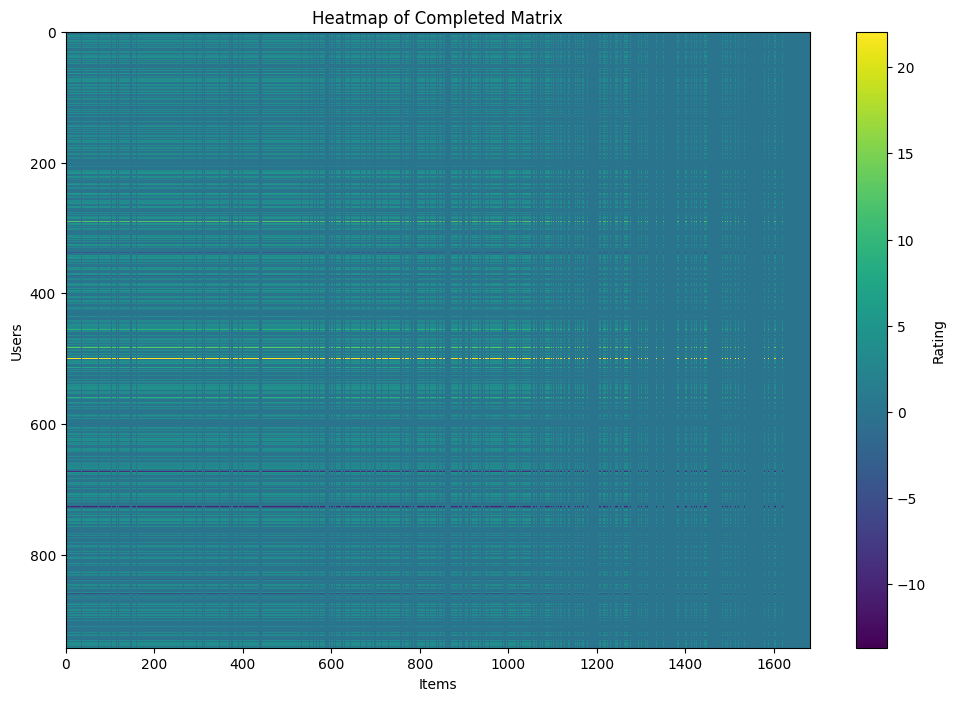

Streaming output truncated to the last 5000 lines.
Alphas shape: (943,)
Observed validation indices count: 942
Validation kernel submatrix shape: (942, 943)
Validation predictions shape: (942,)
Validation Y shape: (942,)
Validation RMSE: 1.4562904424900158
Validation unnormalized RMSE: 1.639299507238194
Validation RMSE for fold 4: 1.4563
Fold 5
Observed train indices count: 943
Shape of X before kernel computation: (1682, 943)
Input X shape before kernel computation: (1682, 943)
Layer 0: Input shape (1682, 943), Weight shape (331, 1682)
Layer 0: Output shape (331, 943)
Layer 1: Input shape (331, 943), Weight shape (331, 331)
Layer 1: Output shape (331, 943)
Outputs shape after forward pass: (331, 943)
Kernel matrix shape: (943, 943)
Kernel matrix shape: (943, 943)
Training kernel submatrix shape: (943, 943)
Training Y shape: (943,)
Alphas shape: (943,)
Observed validation indices count: 941
Validation kernel submatrix shape: (941, 943)
Validation predictions shape: (941,)
Validation Y 

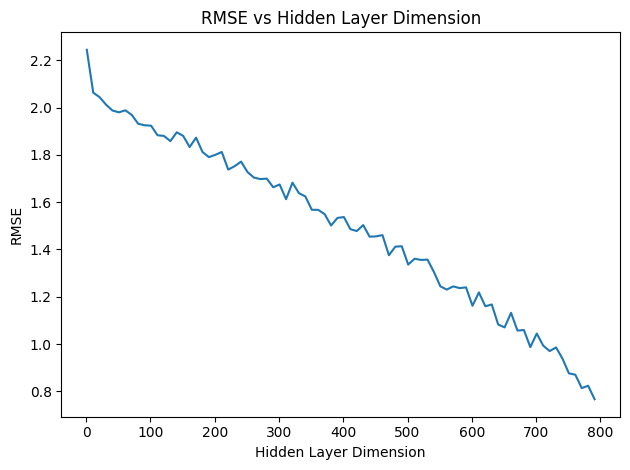

In [8]:
if __name__ == "__main__":
    matrix, n_users, n_items = load_data("u.data")
    matrix, rating_mean, rating_std = normalize_ratings(matrix)
    S = (matrix != 0).astype(int)

    input_dim = n_items
    hidden_dim = 50

    weights = [
        np.random.randn(hidden_dim, input_dim),
        np.random.randn(hidden_dim, hidden_dim)
    ]
    activations = [relu, lambda x: x]
    completed_matrix = complete_matrix_sparse(
        matrix, S, weights, activations, alpha=1e-3, rating_mean=rating_mean, rating_std=rating_std, sample_size=5000
    )
    print("Completed matrix shape:", completed_matrix.shape)

    plot_completed_matrix(completed_matrix, title="Heatmap of Completed Matrix")

rmse_norm = []
rmse_unnorm = []

for hidden_dim in range(1, 801,10):
    input_dim = n_items

    weights = [
        np.random.randn(hidden_dim, input_dim),
        np.random.randn(hidden_dim, hidden_dim)
    ]
    activations = [relu, lambda x: x]

    avg_rmse, avg_unnormalized_rmse = cross_validate(
        matrix.T, matrix.ravel(), S, folds, weights, activations, alpha=1e-3, rating_std=rating_std
    )

    rmse_norm.append(avg_rmse)
    rmse_unnorm.append(avg_unnormalized_rmse)

plt.plot([x for x in range(1,801,10)],rmse_unnorm)
plt.title("RMSE vs Hidden Layer Dimension")
plt.xlabel("Hidden Layer Dimension")
plt.ylabel("RMSE")
plt.tight_layout()
plt.savefig('rmnse_error.png',dpi=400)
plt.show()


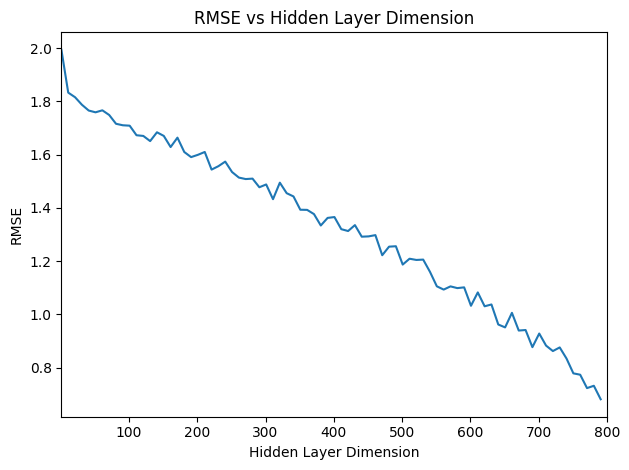

In [9]:
import matplotlib.pyplot as plt
plt.plot([x for x in range(1,801,10)],rmse_norm)
plt.title("RMSE vs Hidden Layer Dimension")
plt.xlabel("Hidden Layer Dimension")
plt.ylabel("RMSE")
plt.xlim(1,800)
plt.tight_layout()
plt.savefig('rmnse_error.png',dpi=400)
plt.show()

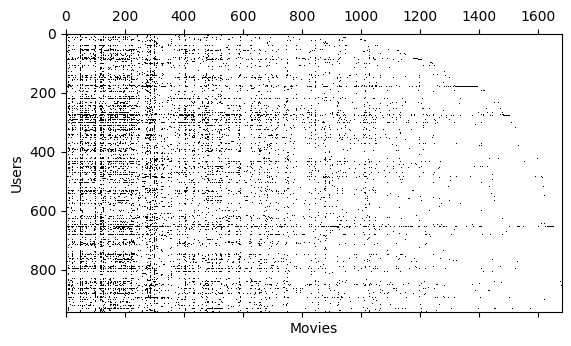

In [10]:
plt.spy(matrix)
plt.xlabel('Movies')
plt.ylabel('Users')
plt.savefig('movie_lens_matrix.png',dpi=400)

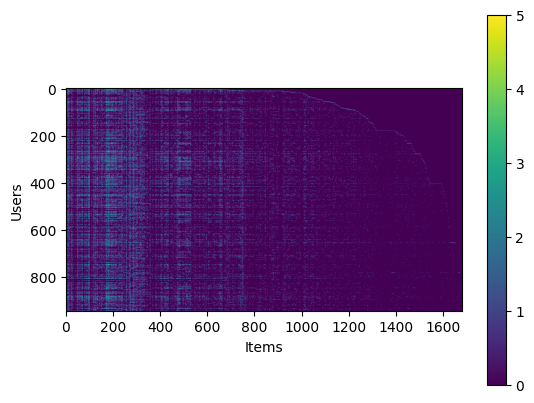

In [11]:
plt.imshow(matrix, cmap='viridis')
plt.colorbar()
plt.xlabel("Items")
plt.ylabel("Users")
plt.show()

Streaming output truncated to the last 5000 lines.
Alphas shape: (943,)
Observed validation indices count: 942
Validation kernel submatrix shape: (942, 943)
Validation predictions shape: (942,)
Validation Y shape: (942,)
Validation RMSE: 0.6921476642243823
Validation unnormalized RMSE: 0.7791284566552911
Validation RMSE for fold 4: 0.6921
Fold 5
Observed train indices count: 943
Shape of X before kernel computation: (1682, 943)
Input X shape before kernel computation: (1682, 943)
Layer 0: Input shape (1682, 943), Weight shape (800, 1682)
Layer 0: Output shape (800, 943)
Layer 1: Input shape (800, 943), Weight shape (800, 800)
Layer 1: Output shape (800, 943)
Outputs shape after forward pass: (800, 943)
Kernel matrix shape: (943, 943)
Kernel matrix shape: (943, 943)
Training kernel submatrix shape: (943, 943)
Training Y shape: (943,)
Alphas shape: (943,)
Observed validation indices count: 941
Validation kernel submatrix shape: (941, 943)
Validation predictions shape: (941,)
Validation Y

ValueError: x and y must have same first dimension, but have shapes (80,) and (1000,)

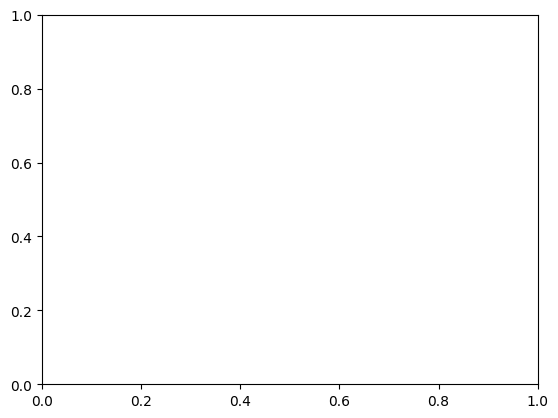

In [12]:
#test learning with different alphas
rmse_norm = []
rmse_unnorm = []

for alpha in np.linspace(0,1,1000):
    input_dim = n_items
    hidden_dim=800
    weights = [
        np.random.randn(hidden_dim, input_dim),
        np.random.randn(hidden_dim, hidden_dim)
    ]
    activations = [relu, lambda x: x]  # ReLU and identity for output layer

    avg_rmse, avg_unnormalized_rmse = cross_validate(
        matrix.T, matrix.ravel(), S, folds, weights, activations, alpha=1e-3, rating_std=rating_std
    )

    rmse_norm.append(avg_rmse)
    rmse_unnorm.append(avg_unnormalized_rmse)



In [14]:
#insertion of attack + plotting error

Fold 1
Observed train indices count: 943
Shape of X before kernel computation: (1682, 953)
Input X shape before kernel computation: (1682, 953)
Layer 0: Input shape (1682, 953), Weight shape (800, 1682)
Layer 0: Output shape (800, 953)
Layer 1: Input shape (800, 953), Weight shape (800, 800)
Layer 1: Output shape (800, 953)
Outputs shape after forward pass: (800, 953)
Kernel matrix shape: (953, 953)
Kernel matrix shape: (953, 953)
Training kernel submatrix shape: (943, 943)
Training Y shape: (943,)
Alphas shape: (943,)
Observed validation indices count: 942
Validation kernel submatrix shape: (942, 943)
Validation predictions shape: (942,)
Validation Y shape: (942,)
Validation RMSE: 0.6773166727274619
Validation unnormalized RMSE: 0.7624336845525606
Validation RMSE for fold 1: 0.6773
Fold 2
Observed train indices count: 943
Shape of X before kernel computation: (1682, 953)
Input X shape before kernel computation: (1682, 953)
Layer 0: Input shape (1682, 953), Weight shape (800, 1682)
Lay

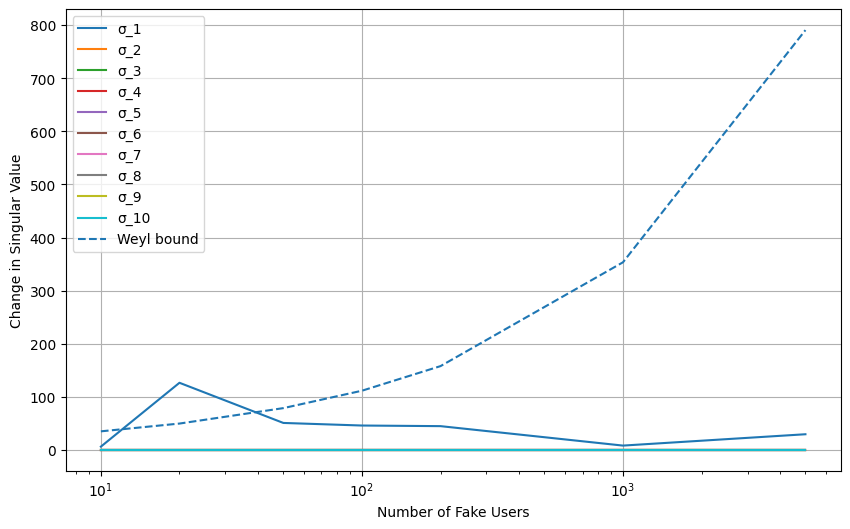

In [21]:
user_counts = [10, 20, 50, 100, 200, 1000, 5000]
results = []
weights = [
        np.random.randn(hidden_dim, input_dim),
        np.random.randn(hidden_dim, hidden_dim)
    ]
activations = [relu, lambda x: x]
avg_rmse, avg_unnormalized_rmse = cross_validate(
    perturbed_matrix.T, perturbed_matrix.ravel(), S, folds, weights, activations, alpha=1e-3, rating_std=rating_std
    )
rmse_norm.append(avg_rmse)
rmse_unnorm.append(avg_unnormalized_rmse)
completed_matrix = complete_matrix_sparse(
        matrix, S, weights, activations, alpha=1e-3, rating_mean=rating_mean, rating_std=rating_std, sample_size=5000
    )
baseline_singular_values = np.linalg.svd(completed_matrix, compute_uv=False)

target_movies = np.random.choice(matrix.shape[1], 5, replace=False)
for num_fake_users in user_counts:
   fake_users = np.zeros((num_fake_users, matrix.shape[1]))
   fake_users[:, target_movies] = 5.0

   weyl_bound = np.linalg.svd(fake_users, compute_uv=False)[0]
   perturbed_matrix = np.vstack([matrix, fake_users])
   weights = [
        np.random.randn(hidden_dim, input_dim),
        np.random.randn(hidden_dim, hidden_dim)
    ]
   activations = [relu, lambda x: x]
   avg_rmse, avg_unnormalized_rmse = cross_validate(
        perturbed_matrix.T, perturbed_matrix.ravel(), S, folds, weights, activations, alpha=1e-3, rating_std=rating_std
    )
   rmse_norm.append(avg_rmse)
   rmse_unnorm.append(avg_unnormalized_rmse)
   completed = complete_matrix_sparse(
        matrix, S, weights, activations, alpha=1e-3, rating_mean=rating_mean, rating_std=rating_std, sample_size=5000
    )

   new_s = np.linalg.svd(completed, compute_uv=False)

   changes = np.abs(new_s[:10] - baseline_singular_values[:10])

   results.append({
       'num_users': num_fake_users,
       'weyl_bound': weyl_bound,
       'changes': changes
   })

plt.figure(figsize=(10, 6))
for i in range(10):
   plt.plot([r['num_users'] for r in results],
            [r['changes'][i] for r in results],
            label=f'σ_{i+1}')
plt.plot([r['num_users'] for r in results],
        [r['weyl_bound'] for r in results],
        '--', label='Weyl bound')
plt.xscale('log')
plt.xlabel('Number of Fake Users')
plt.ylabel('Change in Singular Value')
plt.legend()
plt.grid(True)
plt.show()


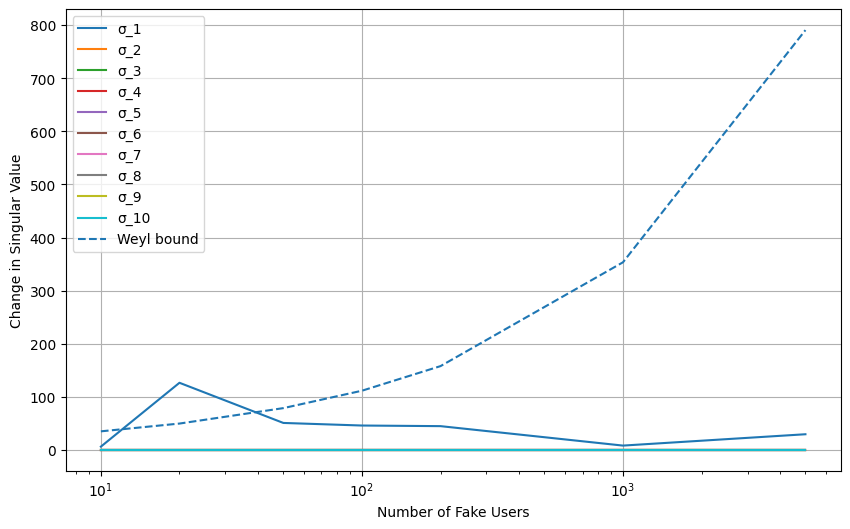

In [22]:
plt.figure(figsize=(10, 6))
for i in range(10):
   plt.plot([r['num_users'] for r in results],
            [r['changes'][i] for r in results],
            label=f'σ_{i+1}')
plt.plot([r['num_users'] for r in results],
        [r['weyl_bound'] for r in results],
        '--', label='Weyl bound')
plt.xscale('log')
plt.xlabel('Number of Fake Users')
plt.ylabel('Change in Singular Value')
plt.legend()
plt.grid(True)
plt.savefig('weyl_bound_ntk.png',dpi=400)
plt.show()
